In [1]:
import scipy.io as scio
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob
import time
import pickle
import cv2
from tensorflow.python.client import device_lib
import math
import pandas as pd
device_lib.list_local_devices()
import shutil
import pathlib
import random
import sys
import colorsys
import copy
from sklearn.preprocessing import StandardScaler
import tensorflow.keras.backend as K
import gc
import sklearn
np.random.seed(2023)
random.seed(2023)

In [8]:
Real_ALL_Time = np.concatenate((Time_series_R,Time_June,Time_New),axis=0)
Real_ALL_Force = np.concatenate((Force_R,Force_June,Force_New ),axis=0)
Real_ALL_Location =  np.concatenate((Location_R,Location_June,Location_New),axis=0)
Temp_list_Real = np.arange(0,len(Real_ALL_Time))
np.random.shuffle(Temp_list_Real)
Real_ALL_Time = Real_ALL_Time[Temp_list_Real]
Real_ALL_Location =Real_ALL_Location[Temp_list_Real]
Real_ALL_Force = Real_ALL_Force[Temp_list_Real]

Train_Real_ALL_Time,Test_Real_ALL_Time = Real_ALL_Time[:int(0.8*len(Real_ALL_Time))], Real_ALL_Time[int(0.8*len(Real_ALL_Time)):]
Train_Real_ALL_Force, Test_Real_ALL_Force = Real_ALL_Force[:int(0.8*len(Real_ALL_Time))],Real_ALL_Force[int(0.8*len(Real_ALL_Time)):]
Train_Real_ALL_Location,Test_Real_ALL_Location = Real_ALL_Location[:int(0.8*len(Real_ALL_Time))],Real_ALL_Location[int(0.8*len(Real_ALL_Time)):]

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os
import tensorflow as tf
from tensorflow import keras, data
from tensorflow.keras import layers, regularizers, activations
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import scipy
from scipy.fft import fft,ifft
import math

class Encoder(layers.Layer):
    def __init__(self, time_step, x_dim, z_dim, name='encoder', **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        
        self.encoder_input = tf.keras.Input(shape=(time_step,x_dim))
        self.Conv1  =tf.keras.layers.Conv1D(16, 5, activation="relu", strides=1, padding="same")
        self.MaxPool1 = tf.keras.layers.MaxPool1D (pool_size=2, strides=2)
        self.Conv2 = tf.keras.layers.Conv1D(32, 5, activation="relu", strides=1, padding="same")
        self.MaxPool2 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2)
        self.Conv3 = tf.keras.layers.Conv1D(64, 5, activation="relu", strides=1, padding="same")
        self.MaxPool3 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2)
        self.Flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(z_dim, activation='linear')
        self.z = layers.Dense(z_dim, name='z')
    
    def call(self, inputs):
        self.encoder_inputs = inputs
        x =  self.Conv1(self.encoder_inputs)
        x = self.MaxPool1(x)
        x = self.Conv2(x)
        x = self.MaxPool2(x)
        x = self.Conv3(x)
        x = self.MaxPool3(x)
        x = self.Flatten(x)
        x = self.dense(x)
        z = self.z(x)
        return z

class Decoder(layers.Layer):
    def __init__(self, time_step, x_dim, z_dim, name='decoder', **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)

        self.dense = tf.keras.layers.Dense(units=int(time_step/16) * z_dim)
        self.Reshape = tf.keras.layers.Reshape((int(time_step/16), z_dim))
        self.Conv1DTranspose1= tf.keras.layers.Conv1DTranspose(64,5,2, padding='same', activation='relu')
        self.Conv1DTranspose2=tf.keras.layers.Conv1DTranspose(32,5,2, padding='same', activation='relu')
        self.Conv1DTranspose3=tf.keras.layers.Conv1DTranspose(16,5,2, padding='same', activation='relu')
        self.decoder_output = tf.keras.layers.Conv1DTranspose(x_dim, 5, 2, padding='same', activation='linear')
    
    def call(self, inputs):
        z = self.dense(inputs)
        z =self.Reshape(z)
        z =self.Conv1DTranspose1(z)
        z =self.Conv1DTranspose2(z)
        z =self.Conv1DTranspose3(z)
        reconstruct_x = self.decoder_output(z)
        
        return reconstruct_x
    
class New_Impact_Discrimination(tf.keras.Model):
    def __init__(self,dim=64):
        super(New_Impact_Discrimination, self).__init__()
        self.embeddinglayer = tf.keras.layers.Dense(dim, activation="relu",)
        self.LSTM1 = tf.keras.layers.LSTM(128, activation="tanh",return_sequences=True)
        self.LSTM2 = tf.keras.layers.LSTM(128, activation="tanh",return_sequences=True)
               
        self.Conv1  =tf.keras.layers.Conv1D(64, 3, activation="relu", strides=1, padding="same")
        self.MaxPool1 = tf.keras.layers.MaxPool1D (pool_size=2, strides=2)
        self.Conv2 = tf.keras.layers.Conv1D(64, 3, activation="relu", strides=1, padding="same")
        self.MaxPool2 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2)
        self.Conv3 = tf.keras.layers.Conv1D(128, 3, activation="relu", strides=1, padding="same")
        self.MaxPool3 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2)
        self.Flatten = tf.keras.layers.Flatten()
   
        self.block1 =[]
        for i in range(3):
            self.block1.append([
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.BatchNormalization(),
            ])

        self.block2 =[]
        for i in range(3):
            self.block2.append([
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.BatchNormalization()
            ])
        
        self.F1 = tf.keras.layers.Dense(64, activation="relu")
        self.F2 = tf.keras.layers.Dense(64, activation="relu")
        self.F3 = tf.keras.layers.Dense(64, activation="relu")
        self.F = tf.keras.layers.Dense(1, activation="relu")
        self.L = tf.keras.layers.Dense(46, activation="softmax")
  
    def call(self, inputs, training=True):
        x  = inputs
        x1 = self.embeddinglayer(x)
        x2 = self.LSTM1(x1)
        x3 = self.LSTM2(x2)
        x4 = self.Conv1(x3)
        x5 = self.MaxPool1(x4)
        x6 = self.Conv2(x5)
        x7 = self.MaxPool2(x6)
        x8 = self.Conv3(x7)
        x9 = self.MaxPool3(x8)
        x10 = self.Flatten(x9)
        x_f = x10
        x_l = x10
     
        for Dense, Batchnorm in self.block1:
            x_f1 = Dense(x_f)
            x_f2 = Batchnorm(x_f1)
            x_f = tf.keras.layers.add([x_f1, x_f2])
        F1=self.F1(x_f)
        F2=self.F2(F1)
        F3=self.F3(F2)
        Output1 = self.F(F3)

        for Dense, Batchnorm in self.block2:
            x_l1 = Dense(x_l)
            x_l2 = Batchnorm(x_l1)
            x_l = tf.keras.layers.add([x_l1, x_l2])  
        Output2 = self.L(x_l)
       
        return Output1, Output2
    
class CNN_AE(keras.Model):
    def __init__(self, time_step, x_dim, z_dim, trainable1,trainable2,trainable3, name='lstm_ae', **kwargs):
        super(CNN_AE, self).__init__(name=name, **kwargs)

        self.encoder = Encoder(time_step, x_dim,  z_dim, **kwargs)
        self.decoder = Decoder(time_step, x_dim,  z_dim, **kwargs)
        self.detect = New_Impact_Discrimination()
        self.trainable1 = trainable1
        self.trainable2 = trainable2
        self.trainable3 = trainable3
        
    def call(self, inputs):
        z = self.encoder(inputs,training = self.trainable1)
        reconstruction = self.decoder(z,training = self.trainable2)
        Force,Location = self.detect(reconstruction,training = self.trainable3)
        return  Force,Location

In [11]:
#########################Part A########################
np.random.seed(2023)
batch = 4
time_step = 1600
x_dim = 11
z_dim = 32
trainable1=True
trainable2=True
trainable3=True
model = CNN_AE(time_step, x_dim, z_dim,trainable1,trainable2,trainable3, dtype='float32')
model.build(input_shape =(None,time_step,x_dim))
model.load_weights('./PartA_AE_woRe_Method1(woMinMax).h5')
out_put_model_file = "./PartA_AE_woRe_Method1(woMinMax).h5"
Callbacks=[
    tf.keras.callbacks.ModelCheckpoint(out_put_model_file,save_best_only=True,save_weights_only =True),
    tf.keras.callbacks.EarlyStopping(patience=10,min_delta=1e-3),
]
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),loss=[tf.keras.losses.MAE,tf.keras.losses.categorical_crossentropy])
history = model.fit(x = Train_Time_series, y=[Train_Force,Train_Location], epochs=100,batch_size=batch,validation_split=0.2,callbacks=Callbacks)

Epoch 1/100
1840/1840 [==============================] - 364s 196ms/step - loss: 1.9308 - output_1_loss: 1.1951 - output_2_loss: 0.7357 - val_loss: 2.5155 - val_output_1_loss: 1.7556 - val_output_2_loss: 0.7598
Epoch 2/100
1840/1840 [==============================] - 371s 201ms/step - loss: 1.7336 - output_1_loss: 1.0250 - output_2_loss: 0.7086 - val_loss: 1.6277 - val_output_1_loss: 0.8953 - val_output_2_loss: 0.7324
Epoch 3/100
1840/1840 [==============================] - 355s 193ms/step - loss: 1.7836 - output_1_loss: 1.0771 - output_2_loss: 0.7065 - val_loss: 1.6970 - val_output_1_loss: 0.9854 - val_output_2_loss: 0.7117
Epoch 4/100
1840/1840 [==============================] - 344s 187ms/step - loss: 1.7415 - output_1_loss: 1.0668 - output_2_loss: 0.6746 - val_loss: 2.2204 - val_output_1_loss: 1.5020 - val_output_2_loss: 0.7184
Epoch 5/100
1840/1840 [==============================] - 365s 199ms/step - loss: 1.6109 - output_1_loss: 0.9453 - output_2_loss: 0.6657 - val_loss: 1.1360 -

[[45  0  0 ...  0  0  0]
 [ 0 41  0 ...  1  0  0]
 [ 0  0 53 ...  0  0  0]
 ...
 [ 0  0  1 ... 58  0  0]
 [ 0  0  0 ...  0 41  0]
 [ 0  0  0 ...  0  0 50]]
0.9478260869565217
0.9514669038609702
0.9478260869565217
0.9464739148360015


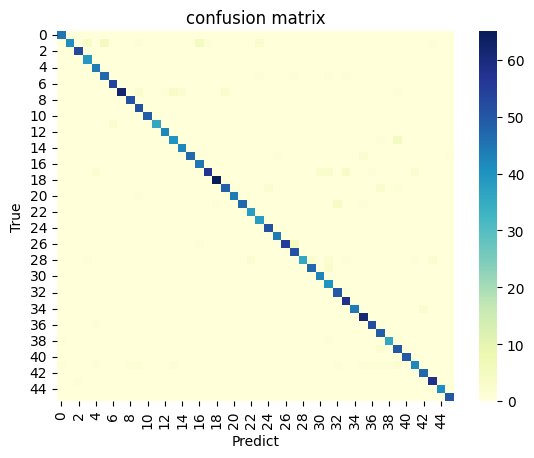

In [18]:
###############测试下#######################
import seaborn as sns
from sklearn.metrics import confusion_matrix
np.random.seed(2023)
batch = 4
time_step = 1600
x_dim = 11
z_dim = 32
trainable1=False
trainable2=False
trainable3=False
model = CNN_AE(time_step, x_dim, z_dim,trainable1,trainable2,trainable3, dtype='float32')
model.build(input_shape =(None,time_step,x_dim))
model.load_weights("./PartA_AE_woRe_Method1(woMinMax).h5")

y_predicted_L = []
y_Real_L = []
Force_p = []
Force_r = []
for count in range(int(len(Test_Time_Series)/4)):
    X =Test_Time_Series[4*count:4*(count+1)]
    F,L = model(X)
    y_predicted_L.extend(np.argmax(L,axis=-1))
    y_Real_L.extend(np.argmax(Test_Location[4*count:4*(count+1)],axis=-1))
    Force_p.extend(F)
    Force_r.extend(Test_Force[4*count:4*(count+1)])
    
f,ax = plt.subplots()
y_true = np.squeeze(y_predicted_L)
y_pred = np.squeeze(y_Real_L)
C2 = confusion_matrix(y_true,y_pred,labels= [i for i in range(0,46)])
print(C2)
sns.heatmap(C2,annot=False,ax=ax,cmap="YlGnBu") #画热力图
ax.set_title('confusion matrix') #标题
ax.set_xlabel('Predict') #x 轴
ax.set_ylabel('True') #y 轴
print(sklearn.metrics.accuracy_score(y_true, y_pred))
print(sklearn.metrics.precision_score(y_true, y_pred,average='weighted'))
print(sklearn.metrics.recall_score(y_true, y_pred,average='weighted'))
print(sklearn.metrics.f1_score(y_true, y_pred,average='weighted'))

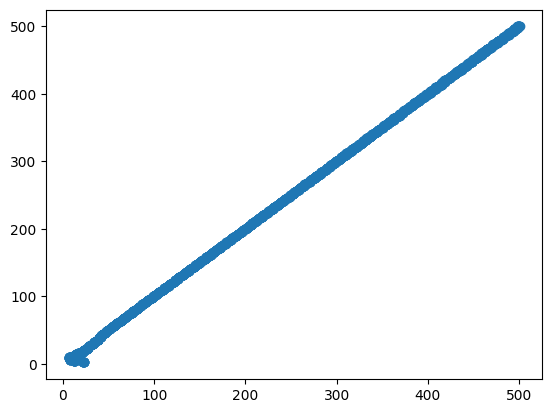

0.07044520350840638


In [20]:
plt.scatter(x=np.squeeze(Force_p),y=np.squeeze(Force_r))
plt.show()
print(sklearn.metrics.mean_absolute_percentage_error(np.squeeze(Force_r), np.squeeze(Force_p)))
SAVEDATA = pd.DataFrame(np.concatenate((np.squeeze(Force_p),np.squeeze(Force_r)),axis=-1))
SAVEDATA.to_excel(r"D:\AI in NTU\Proffu\Results\M1_partA.xlsx")

In [18]:
###############PART b########################
batch = 4
time_step = 1600
x_dim = 11
z_dim = 32
trainable1=True
trainable2=False
trainable3=False
model_B = CNN_AE(time_step, x_dim, z_dim,trainable1,trainable2,trainable3, dtype='float32')
model_B.build(input_shape =(None,time_step,x_dim))
#model_B.load_weights("./PartA_AE_woRe_Method1(woMinMax).h5")
model_B.load_weights("./PartB_AE_woRe_NewALL_Method1(woMinMax).h5")
model_B.compile(optimizer=tf.keras.optimizers.Adam(1e-5),loss=[tf.keras.losses.MAE,tf.keras.losses.categorical_crossentropy])
for i in range(30):
    temp_list = np.random.randint(0,len(Train_Time_series),len(Train_Real_ALL_Time))
    temp_time_series = Train_Time_series[temp_list]
    temp_Force = Train_Force[temp_list]
    temp_Location = Train_Location[temp_list]
    model_B.fit(x = Train_Real_ALL_Time, y=[Train_Real_ALL_Force,Train_Real_ALL_Location], epochs=5,batch_size=batch,validation_split=0.2)
    model_B.fit(x = temp_time_series, y=[temp_Force,temp_Location], epochs=5,batch_size=batch,validation_split=0.2)
model_B.save_weights("./PartB_AE_woRe_NewALL_Method1(woMinMax).h5")

Epoch 1/5
62/62 [==============================] - 16s 205ms/step - loss: 11.1452 - output_1_loss: 11.0587 - output_2_loss: 0.0865 - val_loss: 39.7804 - val_output_1_loss: 39.6677 - val_output_2_loss: 0.1127
Epoch 2/5
62/62 [==============================] - 12s 188ms/step - loss: 11.2290 - output_1_loss: 11.2054 - output_2_loss: 0.0236 - val_loss: 41.0689 - val_output_1_loss: 40.9651 - val_output_2_loss: 0.1038
Epoch 3/5
62/62 [==============================] - 12s 189ms/step - loss: 11.6629 - output_1_loss: 11.6299 - output_2_loss: 0.0330 - val_loss: 39.3992 - val_output_1_loss: 39.2871 - val_output_2_loss: 0.1121
Epoch 4/5
62/62 [==============================] - 12s 192ms/step - loss: 10.8355 - output_1_loss: 10.8139 - output_2_loss: 0.0216 - val_loss: 40.0341 - val_output_1_loss: 39.9308 - val_output_2_loss: 0.1033
Epoch 5/5
62/62 [==============================] - 12s 187ms/step - loss: 11.4734 - output_1_loss: 11.4490 - output_2_loss: 0.0244 - val_loss: 45.4613 - val_output_1_lo

Epoch 1/5
62/62 [==============================] - 12s 202ms/step - loss: 12.4905 - output_1_loss: 12.4546 - output_2_loss: 0.0359 - val_loss: 40.4503 - val_output_1_loss: 40.3157 - val_output_2_loss: 0.1346
Epoch 2/5
62/62 [==============================] - 12s 191ms/step - loss: 10.8549 - output_1_loss: 10.8330 - output_2_loss: 0.0219 - val_loss: 38.8356 - val_output_1_loss: 38.7153 - val_output_2_loss: 0.1203
Epoch 3/5
62/62 [==============================] - 12s 196ms/step - loss: 11.3578 - output_1_loss: 11.3393 - output_2_loss: 0.0186 - val_loss: 40.2409 - val_output_1_loss: 40.1277 - val_output_2_loss: 0.1132
Epoch 4/5
62/62 [==============================] - 13s 208ms/step - loss: 10.6536 - output_1_loss: 10.6333 - output_2_loss: 0.0203 - val_loss: 40.6443 - val_output_1_loss: 40.5292 - val_output_2_loss: 0.1151
Epoch 5/5
62/62 [==============================] - 12s 200ms/step - loss: 10.5528 - output_1_loss: 10.5341 - output_2_loss: 0.0187 - val_loss: 39.3544 - val_output_1_lo

Epoch 1/5
62/62 [==============================] - 12s 194ms/step - loss: 12.6816 - output_1_loss: 12.6225 - output_2_loss: 0.0591 - val_loss: 40.3639 - val_output_1_loss: 40.1916 - val_output_2_loss: 0.1723
Epoch 2/5
62/62 [==============================] - 12s 192ms/step - loss: 12.6425 - output_1_loss: 12.6229 - output_2_loss: 0.0196 - val_loss: 39.2747 - val_output_1_loss: 39.0897 - val_output_2_loss: 0.1850
Epoch 3/5
62/62 [==============================] - 12s 194ms/step - loss: 11.1678 - output_1_loss: 11.1473 - output_2_loss: 0.0206 - val_loss: 40.6482 - val_output_1_loss: 40.5269 - val_output_2_loss: 0.1212
Epoch 4/5
62/62 [==============================] - 12s 193ms/step - loss: 9.4173 - output_1_loss: 9.3969 - output_2_loss: 0.0204 - val_loss: 40.6277 - val_output_1_loss: 40.5252 - val_output_2_loss: 0.1025
Epoch 5/5
62/62 [==============================] - 12s 198ms/step - loss: 9.4972 - output_1_loss: 9.4823 - output_2_loss: 0.0149 - val_loss: 40.6349 - val_output_1_loss: 

Epoch 1/5
62/62 [==============================] - 11s 179ms/step - loss: 10.3454 - output_1_loss: 10.2813 - output_2_loss: 0.0641 - val_loss: 39.8139 - val_output_1_loss: 39.6624 - val_output_2_loss: 0.1515
Epoch 2/5
62/62 [==============================] - 12s 190ms/step - loss: 10.1668 - output_1_loss: 10.1376 - output_2_loss: 0.0292 - val_loss: 41.7692 - val_output_1_loss: 41.6754 - val_output_2_loss: 0.0938
Epoch 3/5
62/62 [==============================] - 11s 183ms/step - loss: 9.0298 - output_1_loss: 9.0073 - output_2_loss: 0.0225 - val_loss: 38.5525 - val_output_1_loss: 38.4675 - val_output_2_loss: 0.0850
Epoch 4/5
62/62 [==============================] - 11s 186ms/step - loss: 8.9787 - output_1_loss: 8.9598 - output_2_loss: 0.0189 - val_loss: 38.3521 - val_output_1_loss: 38.2064 - val_output_2_loss: 0.1457
Epoch 5/5
62/62 [==============================] - 11s 184ms/step - loss: 9.1342 - output_1_loss: 9.1189 - output_2_loss: 0.0153 - val_loss: 38.6771 - val_output_1_loss: 38

Epoch 1/5
62/62 [==============================] - 12s 195ms/step - loss: 10.2844 - output_1_loss: 10.1840 - output_2_loss: 0.1003 - val_loss: 41.7210 - val_output_1_loss: 41.5299 - val_output_2_loss: 0.1910
Epoch 2/5
62/62 [==============================] - 11s 186ms/step - loss: 9.3028 - output_1_loss: 9.2531 - output_2_loss: 0.0497 - val_loss: 40.4395 - val_output_1_loss: 40.2565 - val_output_2_loss: 0.1829
Epoch 3/5
62/62 [==============================] - 12s 187ms/step - loss: 8.5404 - output_1_loss: 8.5252 - output_2_loss: 0.0151 - val_loss: 39.7843 - val_output_1_loss: 39.6864 - val_output_2_loss: 0.0979
Epoch 4/5
62/62 [==============================] - 12s 197ms/step - loss: 9.4389 - output_1_loss: 9.4152 - output_2_loss: 0.0237 - val_loss: 37.5597 - val_output_1_loss: 37.3856 - val_output_2_loss: 0.1741
Epoch 5/5
62/62 [==============================] - 12s 197ms/step - loss: 9.5211 - output_1_loss: 9.5037 - output_2_loss: 0.0174 - val_loss: 41.3421 - val_output_1_loss: 41.2

Epoch 1/5
62/62 [==============================] - 12s 199ms/step - loss: 8.5890 - output_1_loss: 8.5594 - output_2_loss: 0.0296 - val_loss: 39.4632 - val_output_1_loss: 39.2709 - val_output_2_loss: 0.1923
Epoch 2/5
62/62 [==============================] - 12s 189ms/step - loss: 8.3574 - output_1_loss: 8.3433 - output_2_loss: 0.0142 - val_loss: 39.4916 - val_output_1_loss: 39.3870 - val_output_2_loss: 0.1046
Epoch 3/5
62/62 [==============================] - 12s 202ms/step - loss: 8.1555 - output_1_loss: 8.1413 - output_2_loss: 0.0141 - val_loss: 39.7454 - val_output_1_loss: 39.6443 - val_output_2_loss: 0.1011
Epoch 4/5
62/62 [==============================] - 12s 198ms/step - loss: 7.6276 - output_1_loss: 7.6143 - output_2_loss: 0.0133 - val_loss: 38.4140 - val_output_1_loss: 38.3147 - val_output_2_loss: 0.0993
Epoch 5/5
62/62 [==============================] - 12s 198ms/step - loss: 7.7915 - output_1_loss: 7.7646 - output_2_loss: 0.0270 - val_loss: 40.2797 - val_output_1_loss: 40.149

Epoch 1/5
62/62 [==============================] - 12s 195ms/step - loss: 7.5672 - output_1_loss: 7.5439 - output_2_loss: 0.0233 - val_loss: 37.7369 - val_output_1_loss: 37.5304 - val_output_2_loss: 0.2064
Epoch 2/5
62/62 [==============================] - 12s 195ms/step - loss: 7.4847 - output_1_loss: 7.4694 - output_2_loss: 0.0153 - val_loss: 38.2643 - val_output_1_loss: 38.1069 - val_output_2_loss: 0.1573
Epoch 3/5
62/62 [==============================] - 12s 195ms/step - loss: 7.1875 - output_1_loss: 7.1703 - output_2_loss: 0.0172 - val_loss: 38.8022 - val_output_1_loss: 38.6824 - val_output_2_loss: 0.1199
Epoch 4/5
62/62 [==============================] - 12s 199ms/step - loss: 7.7959 - output_1_loss: 7.7863 - output_2_loss: 0.0096 - val_loss: 38.3207 - val_output_1_loss: 38.2091 - val_output_2_loss: 0.1116
Epoch 5/5
62/62 [==============================] - 13s 215ms/step - loss: 7.4876 - output_1_loss: 7.4701 - output_2_loss: 0.0175 - val_loss: 38.2727 - val_output_1_loss: 38.017

Epoch 1/5
62/62 [==============================] - 12s 198ms/step - loss: 7.8753 - output_1_loss: 7.8288 - output_2_loss: 0.0465 - val_loss: 37.7482 - val_output_1_loss: 37.5594 - val_output_2_loss: 0.1887
Epoch 2/5
62/62 [==============================] - 12s 191ms/step - loss: 7.6346 - output_1_loss: 7.6207 - output_2_loss: 0.0140 - val_loss: 39.6249 - val_output_1_loss: 39.5208 - val_output_2_loss: 0.1041
Epoch 3/5
62/62 [==============================] - 12s 198ms/step - loss: 6.8990 - output_1_loss: 6.8897 - output_2_loss: 0.0093 - val_loss: 38.0183 - val_output_1_loss: 37.9048 - val_output_2_loss: 0.1135
Epoch 4/5
62/62 [==============================] - 13s 203ms/step - loss: 7.0968 - output_1_loss: 7.0864 - output_2_loss: 0.0104 - val_loss: 37.9618 - val_output_1_loss: 37.8169 - val_output_2_loss: 0.1449
Epoch 5/5
62/62 [==============================] - 13s 209ms/step - loss: 7.6285 - output_1_loss: 7.6168 - output_2_loss: 0.0117 - val_loss: 37.8155 - val_output_1_loss: 37.628

[[46  0  0 ...  0  0  0]
 [ 0 41  0 ...  0  0  0]
 [ 0  0 54 ...  0  0  0]
 ...
 [ 1  0  0 ... 61  0  0]
 [ 0  0  0 ...  0 41  0]
 [ 0  0  0 ...  0  0 50]]
0.9904347826086957
0.9906661535890978
0.9904347826086957
0.9903466878589293


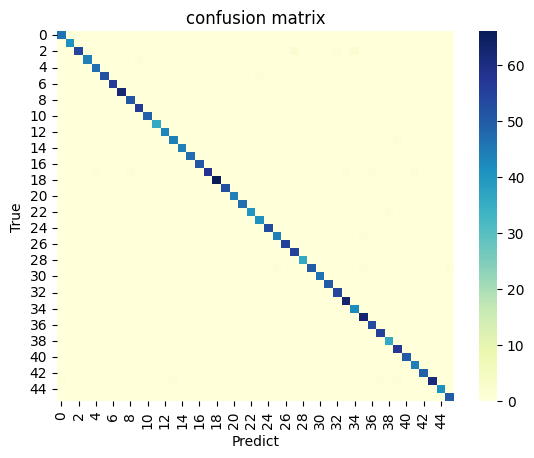

In [21]:
###############测试下#######################
import seaborn as sns
from sklearn.metrics import confusion_matrix
np.random.seed(2023)
batch = 4
time_step = 1600
x_dim = 11
z_dim = 32
trainable1=False
trainable2=False
trainable3=False
model = CNN_AE(time_step, x_dim, z_dim,trainable1,trainable2,trainable3, dtype='float32')
model.build(input_shape =(None,time_step,x_dim))
model.load_weights("./PartB_AE_woRe_NewALL_Method1(woMinMax).h5")

y_predicted_L = []
y_Real_L = []
Force_p = []
Force_r = []
for count in range(int(len(Test_Time_Series)/4)):
    X =Test_Time_Series[4*count:4*(count+1)]
    F,L = model(X)
    y_predicted_L.extend(np.argmax(L,axis=-1))
    y_Real_L.extend(np.argmax(Test_Location[4*count:4*(count+1)],axis=-1))
    Force_p.extend(F)
    Force_r.extend(Test_Force[4*count:4*(count+1)])
    
f,ax = plt.subplots()
y_true = np.squeeze(y_predicted_L)
y_pred = np.squeeze(y_Real_L)
C2 = confusion_matrix(y_true,y_pred,labels= [i for i in range(0,46)])
print(C2)
sns.heatmap(C2,annot=False,ax=ax,cmap="YlGnBu") #画热力图
ax.set_title('confusion matrix') #标题
ax.set_xlabel('Predict') #x 轴
ax.set_ylabel('True') #y 
print(sklearn.metrics.accuracy_score(y_true, y_pred))
print(sklearn.metrics.precision_score(y_true, y_pred,average='weighted'))
print(sklearn.metrics.recall_score(y_true, y_pred,average='weighted'))
print(sklearn.metrics.f1_score(y_true, y_pred,average='weighted'))

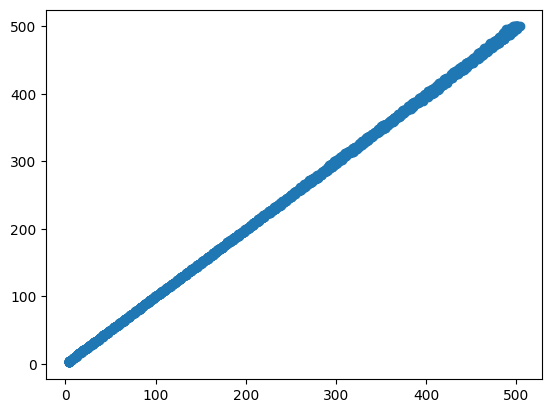

0.012061248315845999


In [22]:
plt.scatter(x=np.squeeze(Force_p),y=np.squeeze(Force_r))
plt.show()
print(sklearn.metrics.mean_absolute_percentage_error(np.squeeze(Force_r), np.squeeze(Force_p)))
SAVEDATA = pd.DataFrame(np.concatenate((np.squeeze(Force_p),np.squeeze(Force_r)),axis=-1))
SAVEDATA.to_excel(r"D:\AI in NTU\Proffu\Results\M1_partB_N.xlsx")

[[3 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
0.8552631578947368
0.8731359649122807
0.8552631578947368
0.8598450072549795


D:\Anaconda\envs\Tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


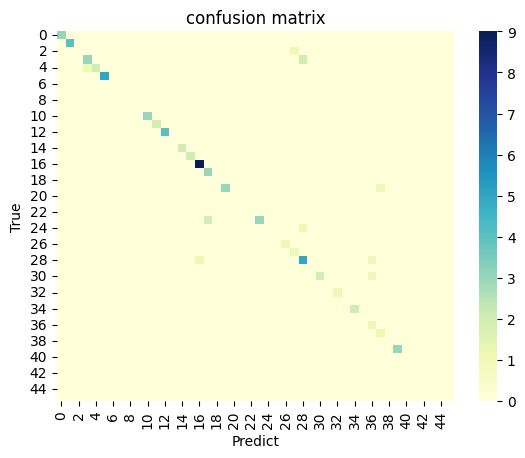

In [23]:
###############测试下#######################
import seaborn as sns
from sklearn.metrics import confusion_matrix
np.random.seed(2023)
batch = 4
time_step = 1600
x_dim = 11
z_dim = 32
trainable1=False
trainable2=False
trainable3=False
model = CNN_AE(time_step, x_dim, z_dim,trainable1,trainable2,trainable3, dtype='float32')
model.build(input_shape =(None,time_step,x_dim))
model.load_weights("./PartB_AE_woRe_NewALL_Method1(woMinMax).h5")

y_predicted_L = []
y_Real_L = []
Force_p = []
Force_r = []
for count in range(int(len(Test_Real_ALL_Time )/4)):
    X = Test_Real_ALL_Time [4*count:4*(count+1)]
    F,L = model(X)
    y_predicted_L.extend(np.argmax(L,axis=-1))
    y_Real_L.extend(np.argmax(Test_Real_ALL_Location[4*count:4*(count+1)],axis=-1))
    Force_p.extend(F+0.3)
    Force_r.extend(Test_Real_ALL_Force[4*count:4*(count+1)])
    
f,ax = plt.subplots()
y_true = np.squeeze(y_predicted_L)
y_pred = np.squeeze(y_Real_L)
C2 = confusion_matrix(y_true,y_pred,labels= [i for i in range(0,46)])
print(C2)
sns.heatmap(C2,annot=False,ax=ax,cmap="YlGnBu") #画热力图
ax.set_title('confusion matrix') #标题
ax.set_xlabel('Predict') #x 轴
ax.set_ylabel('True') #y 轴
print(sklearn.metrics.accuracy_score(y_true, y_pred))
print(sklearn.metrics.precision_score(y_true, y_pred,average='weighted'))
print(sklearn.metrics.recall_score(y_true, y_pred,average='weighted'))
print(sklearn.metrics.f1_score(y_true, y_pred,average='weighted'))

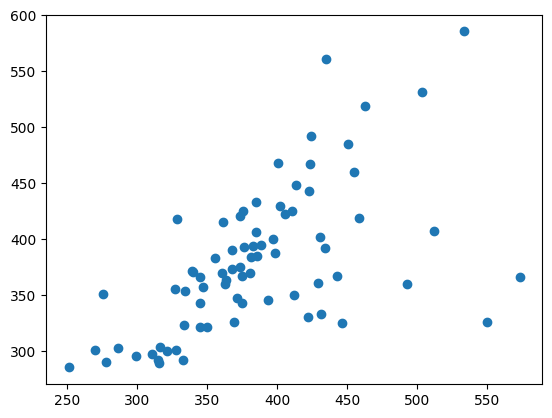

0.10630602329511381


In [24]:
plt.scatter(x=np.squeeze(Force_p),y=np.squeeze(Force_r))
plt.show()
print(sklearn.metrics.mean_absolute_percentage_error(np.squeeze(Force_r), np.squeeze(Force_p)))
SAVEDATA = pd.DataFrame(np.concatenate((np.squeeze(Force_p),np.squeeze(Force_r)),axis=-1))
SAVEDATA.to_excel(r"D:\AI in NTU\Proffu\Results\M1_partB_R.xlsx")